# stock dataset

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceSubsample,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator
from opendataval.model.mlp import RegressionMLP

import warnings
warnings.filterwarnings("ignore")

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


## [Step 1] Set up an environment

### [Step 1-1] Define a DataFetcher from a registered dataset
`ExperimentMediator.model_factory_setup()` is convenient, but it only works for datasets registered in `opendataval`. To apply `opendataval` to your custome datasets, a user first needs to define a `DataFetcher` from a registered dataset. 

In [2]:
dataset_name = "stock"
train_count, valid_count, test_count = 100, 50, 50
noise_rate = 0.1
metric_name = "neg_mse"

fetcher = (
    DataFetcher(dataset_name, '../data_files/', False)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(add_gauss_noise, noise_rate=noise_rate)
)

### [Step 1-2] Set up a prediction model
Next is to set up a prediction model. The following code defines a multi-layer perceptron with two hidden layers. Each hidden layer has 25 nodes.

In [3]:
pred_model = RegressionMLP(fetcher.covar_dim[0], layers=2, hidden_dim=25)

### [Step 1-3] Combining all 
- Combining [Step 1-1] and [Step 1-2] with `ExperimentMediator`

In [4]:
exper_med = ExperimentMediator(fetcher, pred_model)

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [5]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceSubsample(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    DataShapley(gr_threshold=1.05, cache_name=f"cached"), # Data-Shapley
    BetaShapley(gr_threshold=1.05, cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
    RobustVolumeShapley(gr_threshold=1.05)
]

In [6]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.001438


100%|██████████| 100/100 [00:00<00:00, 876.66it/s]


Elapsed time LeaveOneOut(): 0:00:00.143133


100%|██████████| 1000/1000 [00:00<00:00, 1150.48it/s]


Elapsed time InfluenceSubsample(num_models=1000): 0:00:00.870795


100%|██████████| 2000/2000 [00:02<00:00, 939.45it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:02.137584


100%|██████████| 99/99 [00:00<00:00, 32057.14it/s]

Elapsed time KNNShapley(k_neighbors=50): 0:00:00.005026
Start: marginal contribution computation



100%|██████████| 100/100 [00:05<00:00, 17.17it/s]


gr_stat=100


100%|██████████| 100/100 [00:05<00:00, 16.97it/s]


gr_stat=100


100%|██████████| 100/100 [00:05<00:00, 16.89it/s]


gr_stat=100


100%|██████████| 100/100 [00:05<00:00, 17.42it/s]


gr_stat=100


100%|██████████| 100/100 [00:05<00:00, 17.16it/s]

gr_stat=1.0119919051474844
Total number of trained models to estimate marginal
               contributions: 42533
Done: marginal contribution computation


Elapsed time DataShapley(gr_threshold=1.05, cache_name=cached): 0:00:29.210268
Elapsed time BetaShapley(gr_threshold=1.05, cache_name=cached): 0:00:00.000516


100%|██████████| 1000/1000 [00:00<00:00, 1440.27it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:00.696667


100%|██████████| 1000/1000 [00:00<00:00, 1108.93it/s]


Elapsed time AME(num_models=1000): 0:00:02.730060


100%|██████████| 1000/1000 [00:01<00:00, 861.78it/s]


Elapsed time DataOob(num_models=1000): 0:00:01.162014


Elapsed time LavaEvaluator(): 0:00:00.010543
Start: marginal contribution computation


100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


gr_stat=100


100%|██████████| 100/100 [00:06<00:00, 14.75it/s]


gr_stat=100


100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


gr_stat=100


100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


gr_stat=100


100%|██████████| 100/100 [00:06<00:00, 14.75it/s]

gr_stat=1.0125309353132472
Total number of trained models to estimate marginal
               contributions: 47500
Done: marginal contribution computation
Elapsed time RobustVolumeShapley(gr_threshold=1.05): 0:00:33.904468
CPU times: user 1min 8s, sys: 8.75 s, total: 1min 17s
Wall time: 1min 10s


## [Step 3] Evaluate data values

In [7]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/stock_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: perturbed features with additive Gaussian noise

In [8]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.192771
"BetaShapley(gr_threshold=1.05, cache_name=cached)",0.170732
DVRL(rl_epochs=2000),0.185567
DataBanzhaf(num_models=1000),0.166667
DataOob(num_models=1000),0.051282
"DataShapley(gr_threshold=1.05, cache_name=cached)",0.176471
InfluenceSubsample(num_models=1000),0.153846
KNNShapley(k_neighbors=50),0.000000
LavaEvaluator(),0.444444
LeaveOneOut(),0.157895


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

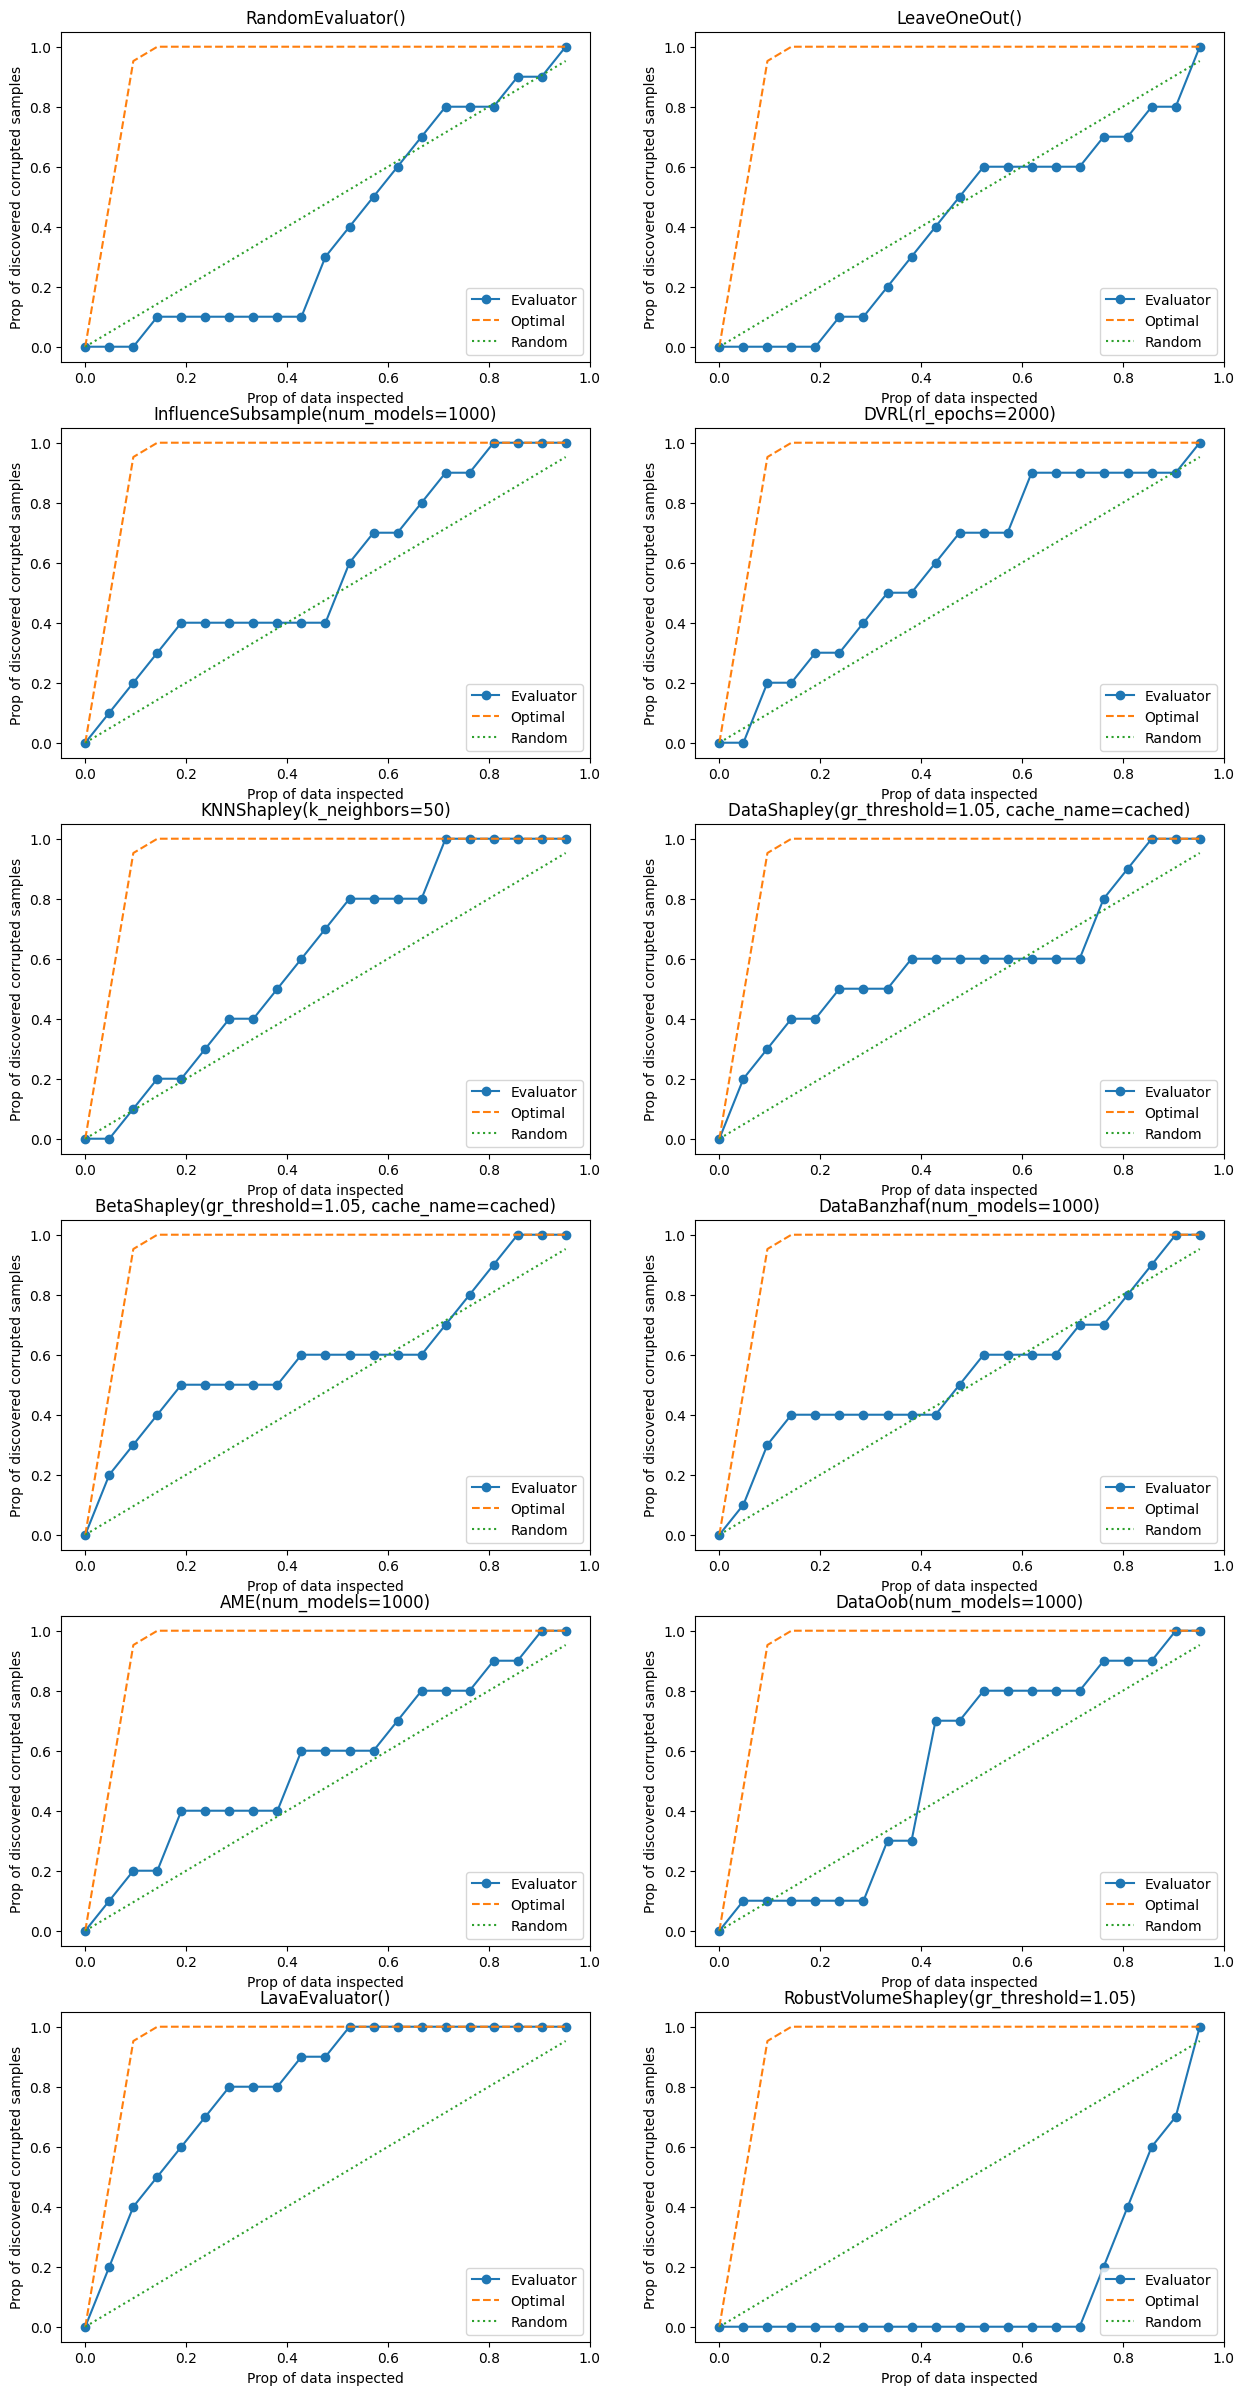

In [9]:
fig = plt.figure(figsize=(15, 30))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

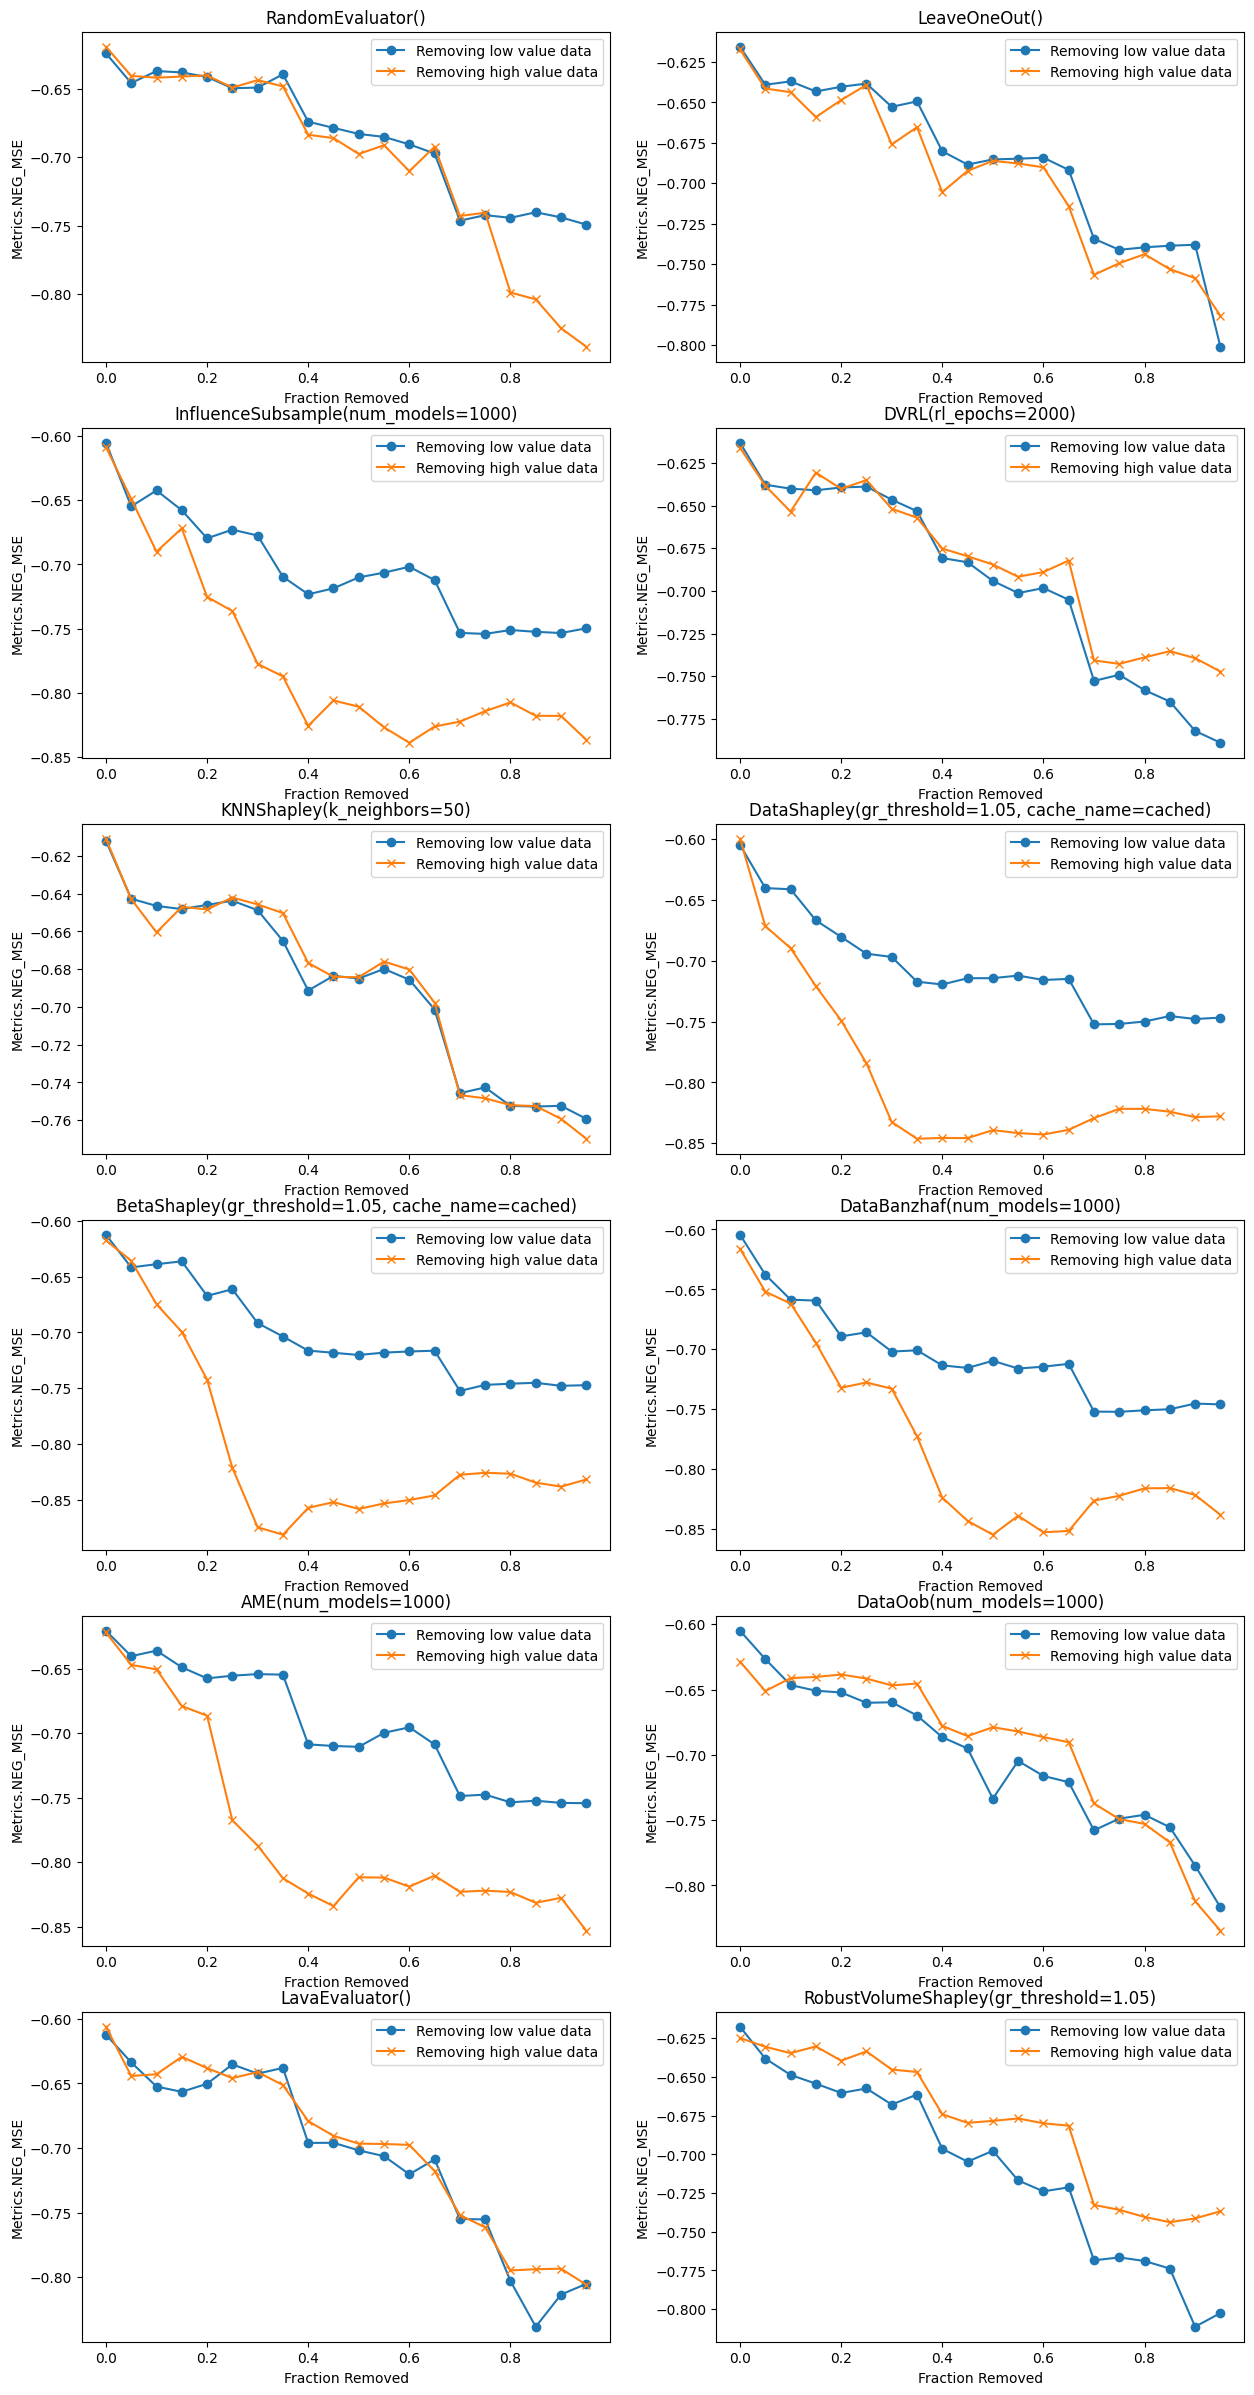

In [10]:
fig = plt.figure(figsize=(15, 30))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, save_output=True)

In [11]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.NEG_MSE,remove_most_influential_first_Metrics.NEG_MSE,axis
RandomEvaluator(),-0.62412,-0.619293,0.0
RandomEvaluator(),-0.645852,-0.640613,0.05
RandomEvaluator(),-0.637046,-0.641903,0.1
RandomEvaluator(),-0.638095,-0.64106,0.15
RandomEvaluator(),-0.641346,-0.640263,0.2
...,...,...,...
RobustVolumeShapley(gr_threshold=1.05),-0.766618,-0.735841,0.75
RobustVolumeShapley(gr_threshold=1.05),-0.768903,-0.74042,0.8
RobustVolumeShapley(gr_threshold=1.05),-0.773815,-0.74383,0.85
RobustVolumeShapley(gr_threshold=1.05),-0.811404,-0.741381,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [12]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),32285,0.601495
RandomEvaluator(),38931,0.344823
RandomEvaluator(),8997,0.663055
RandomEvaluator(),4645,0.543073
RandomEvaluator(),36040,0.047147
...,...,...
RobustVolumeShapley(gr_threshold=1.05),56172,2757497.547433
RobustVolumeShapley(gr_threshold=1.05),4726,3106450.994925
RobustVolumeShapley(gr_threshold=1.05),50776,1501412.48963
RobustVolumeShapley(gr_threshold=1.05),53962,3291126.829919
